**Incomplete - Work In Progress**
# Gaussian Process Regression
This notebook introduces the theory underpinning Gaussian process regression and provides a basic walk-through in python.

## Regression
The goal of regression is to predict the value of one or more continuous target variables $y$ given the value of a $D$-dimensional vector $x$ of input variables. More specifically, given a training data set of $N$ observations $\mathbf{X} = \{x_n\}$, where $n = 1,...,N$, together with corresponding target values $\mathbf{Y} = \{y_n\}$, the task of regression is to predict the value of $y$ for a new value of $x$. The target and observed variates are related through a mapping,

$$f : X \rightarrow Y$$

where $f$ indicates the mapping. 

## Gaussian Process Motivation
Specifying parametric models for regression problems can be tricky because it requires a lot of knowledge about the data. From a Bayesian's perspective this could be viewed as not only having uncertainty in the parameters of the mapping but also in the form of the mapping itself. 

We would therefore like to formulate our uncertainty about the mapping into a prior over mappings and then use Bayes rule to reach the posterior. However, this requires us to formulate a prior over a space of functions! Luckily, a Gaussian process can be used to represent a prior distribution over a space of functions. No parametric form of the underlying function needs to be specified as Gaussian processes are non-parametric models.


non-parametric prior over the space of functions

take account of noise on observed target values
Here, we further make assumptions about the structure of the noise in our observed data, that it has been corrupted by additive Gaussian noise,

$$\mathbf{y}_n = \mathbf{W} \mathbf{x}_n + \epsilon,$$

where $\epsilon \sim \mathcal{N}(0, \sigma^2 \mathbf{I})$.


This prior represents a probability distribution directly over the functions f (x) with zero mean. The covariance matrix k(X, X) is a function that calculates how all of the locations on the input axis vary with one and other, i.e. it computes the covariance between all input locations. If input points xn and xm are similar then the corresponding f(xn) and f(xm) will be strongly correlated in comparison to less similar points. The prior represents functions of f that are all jointly Gaussian, where the covariance matrix encodes the behavior of the function.

## Let's Begin

For more detailed covergae of the information in this notebook please refer to [Rasmussen and Williams book (Gaussian Processes for Machine Learning)](http://www.gaussianprocess.org/gpml/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import cdist

In this notebook we only consider the squared exponential (SE) covariance function, however, other covariance functions exist. The covariance function specifies the covariance between pairs of random variables,

$$ \text{cov}(f(\mathbf{x}_p), f(\mathbf{x}_q)) = k(\mathbf{x}_p, \mathbf{x}_q) = \text{exp}(- \frac{1}{2}|\mathbf{x}_p - \mathbf{x}_q|^2).$$

The characteristic lengthscale of this equation is around 1. By replacing $|\mathbf{x}_p - \mathbf{x}_q|$ with $\frac{|\mathbf{x}_p - \mathbf{x}_q|}{l}$, where $l$ is a positive constant, we can control the characteristic lengthscale. Lets now implement the squared exponential covariance function.

In [2]:
def kernel(x1, x2, s_f, l):
    """Squared exponential kernel"""
    return s_f**2 * np.exp((-cdist(x1, x2)**2) / (2*l**2))

This specification of a covariance function implies a distribution over functions. We can visualise this by drawing samples from the "distribution over functions" at a fixed number of points. Lets select a number of input points $X_*$ to evaluate.

In [3]:
n = 100  # number of test points
x_min = -5
x_max = 5
x_star = np.linspace(x_min*1.4, x_max*1.4, n).reshape(-1,1) # points we're going to make predictions at

Using this covariance matrix, lets now generate a random Gaussian vector,

$$\mathbf{f}_* \sim \mathcal{N}(\mathbf{0}, K(X_*, X_*)),$$

and plot the generated values as a function of the inputs. 

In order to do this lets first express our multivariate normal in terms of standard normals, i.e. in the form $\mathbf{f}_* \sim \mu + \mathbf{B} \mathcal{N}(0, \mathbf{I})$, where $\mathbf{B}\mathbf{B}^T = K(X_*, X_*)$. $\mathbf{B}$ is essentially the square root of the covariance matrix and can be obtained using the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition). This method is based on Section 2.2 (page 15) and Section A.2 (page 201) from [Rasmussen and Williams](http://www.gaussianprocess.org/gpml/).

Lets now create our prior covariance and sample "functions" from it using the Cholesky decomposition. Lets also calculate and plot the pointwise mean $\pm$ two standard deviations for each input value (corresponding to the 95% confidence region), for the prior distribution.

In [4]:
l = 1 # lengthscale hyper-parameter
# s_n = 1e-5  # noise variance
s_f = 1  # signal variance
epsilon = 1e-10  # small number to ensure numerical stability of (eigenvalues of K can decay rapidly)

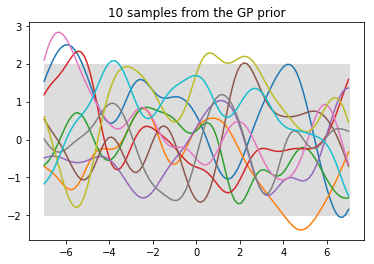

In [5]:
Kss = kernel(x_star, x_star, s_f, l)  # prior covariance

# draw samples from the prior 
Ns = 10 # number of samples

# cholesky decomposition (square root) of covariance matrix K(x_star, x_star)
Lss = np.linalg.cholesky(Kss + epsilon*np.eye(Kss.shape[0]))  # TODO: should this be noise variance s_n????
f_prior = Lss @ np.random.normal(0, 1, size=(n, Ns))  # express x∼N(μ,σ^2) as x∼μ+σ(N(0,1))

# compute standard deviation for plotting
std = np.sqrt(np.diag(Kss))

# plot the sampled values as functions of x_star
plt.plot(x_star, f_prior)
plt.fill_between(x_star.flatten(), 0-2*std, 2*std, color="#dddddd")
plt.title('%i samples from the GP prior' % Ns)
plt.show()

## Predicition with Noise Free Observations

We are not primarily interested in drawing random functions from our prior but instead want to incorporate the information contained in the training data with the prior. Lets consider our observations to be noise free, that is, we know $\{(\mathbf{x}_i, f_i) | i = 1,...,n\}$. The joint distribution between the training targets $\mathbf{f}$ and the test targets $\mathbf{f}_*$ is given then by,

\begin{align}
\begin{bmatrix}
\mathbf{f}\\
\mathbf{f}_*\\
\end{bmatrix} &\sim  \mathcal{N}
\begin{pmatrix}
\mathbf{0},
\begin{bmatrix}
K(X, X) & K(X, X_*) \\
K(X_*, X) & K(X_*, X_*)
\end{bmatrix}
\end{pmatrix}.
\end{align}

Conditioning the joint Gaussian prior distribution on the observations leads to the key predictive equations for Gaussian process regression,

$$\mathbf{f}_* | X, X_*, \mathbf{f} \sim \mathcal{N}(\bar{\mathbf{f}}_*, \text{cov}(\mathbf{f}_*)).$$

Function values can be sampled from the joint posterior distribution by evaluating the mean and covariance matrices, given by,

\begin{align}
\bar{\mathbf{f}}_* &\triangleq \mathbb{E}[\mathbf{f}_* | X, X_*, \mathbf{f}] = K(X_*, X)K(X,X)^{-1}\mathbf{f} \\
\text{cov}(\mathbf{f}_*) &= K(X_*, X_*) - K(X_*, X)K(X,X)^{-1} K(X, X_*)
\end{align}

Lets create the underlying function that we are trying to recover (the sine function).

In [6]:
f = lambda x: np.sin(x) # underlying function

Lets generate some training inputs and map them through our function $\mathbf{f}$ to obtain our training data set $\{(\mathbf{x}_i, f_i) | i = 1,...,n \}$. Lets also visualise our training data set and our underlying function.

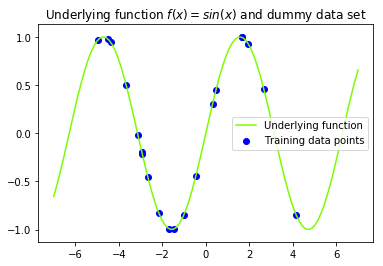

In [7]:
N = 20  # number of training points
 
x_train = np.random.uniform(x_min, x_max, size=(N, 1))  # training inputs
# x_train = np.linspace(x_min, x_max, N).reshape(N, 1)  # training inputs
y_train = f(x_train)  # training outputs (f) - these are noise free observations of the underlying function f

plt.title('Underlying function $f(x)=sin(x)$ and dummy data set ')
plt.plot(x_star, f(x_star), color='lawngreen', label='Underlying function')
plt.scatter(x_train, y_train, color='b', label='Training data points')
plt.legend()
plt.show()

We want to combine our training data with our Gaussian process prior in order to reach the joint posterior distribution. As we saw earlier we can condition the joint Gaussian prior distribution on the observations, where the predictive mean and variance are given by,

\begin{align}
\bar{\mathbf{f}}_* &= K(X_*, X)K(X,X)^{-1}\mathbf{f}, \\
\text{cov}(\mathbf{f}_*) &= K(X_*, X_*) - K(X_*, X)K(X,X)^{-1} K(X, X_*).
\end{align}

[Rasmussen and Williams](http://www.gaussianprocess.org/gpml/) provide a practical algorithm for implementing Gaussian process regression, calculating  both the predictive mean $\bar{f}_*$ and covariance $\mathbb{V}[f_*]$,

**input**: $\mathbf{X}$ (inputs), $\mathbf{y}$ (targets), $k$ (covariance function), $\sigma_n^2$ (noise level), $\mathbf{x}_*$ (test input)

\begin{align}
L &:= \text{cholesky}(K + \sigma_n^2 I) \\
\mathbf{\alpha} &:= L^T\backslash(L\backslash\mathbf{y}) \\
\bar{f}_* &:= \mathbf{k}_*^T\mathbf{\alpha} \\
\mathbf{v} &:= L \backslash \mathbf{k}_* \\
\mathbb{V}[f_*] &:= k(\mathbf{x}_*, \mathbf{x}_*) - \mathbf{v}^T \mathbf{v}
\end{align}

**return**: $\bar{f}_*$ (mean), $\mathbb{V}[f_*]$ (variance)

This algorithm addresses the matrix inversion and uses the Cholesky factorization.

In [8]:
def gp_regression(X, y, k, x_star, s_f, l):
    # calculate mean
    Lxx = np.linalg.cholesky(k(X, X, s_f, l)) # TODO: should noise variance or epsilon be added to noise free case???
    a = np.linalg.solve(Lxx.T, np.linalg.solve(Lxx, y))
    mu = k(X, x_star, s_f, l).T @ a
    
    # calculate variance
    v = np.linalg.solve(Lxx, k(X, x_star, s_f, l))
    var = k(x_star, x_star, s_f, l) - v.T @ v

    return mu, var

In [9]:
def sample(mu, var, epsilon, N):
    L = np.linalg.cholesky(var + epsilon*np.eye(n))
    f_post = mu + L @ np.random.normal(size=(n, N))
    return f_post

In [10]:
# s_f = 1  # signal variance
# s_n = 1e-6  # noise variance
# l = 1  # lengthscale

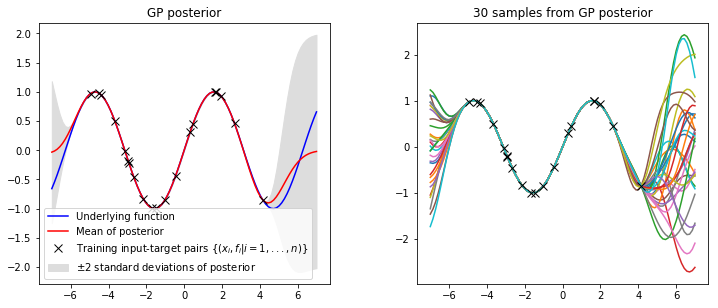

In [11]:
l = 1 # lengthscale hyper-parameter
# s_n = 1e-5  # noise variance
s_f = 1  # signal variance
mu, var = gp_regression(x_train, y_train, kernel, x_star, s_f, l)
std = np.diag(var)

num_samples = 30
f_post = sample(mu, var, epsilon, num_samples)

fig = plt.figure(figsize=(12, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# plot underlying function, training data, posterior mean and +/- 2 standard deviations
plt.subplot(2, 2, 1)
plt.title('GP posterior')
plt.fill_between(x_star.flatten(), mu.flatten()-2*std, mu.flatten()+2*std, label='$\pm$2 standard deviations of posterior', color="#dddddd")
plt.plot(x_star, f(x_star), 'b-', label='Underlying function')
plt.plot(x_star, mu, 'r-', label='Mean of posterior')  # plot mean of posterior
plt.plot(x_train, y_train, 'kx', ms=8 ,label='Training input-target pairs $\{(x_i, f_i | i = 1,...,n)\}$')
plt.legend()

# plot samples from posterior
plt.subplot(2, 2, 2)
plt.title('%i samples from GP posterior' % num_samples)
plt.plot(x_star, f_post)  # plot samples from posterior
plt.plot(x_train, y_train, 'kx', ms=8 ,label='Training input-target pairs $\{(x_i, f_i | i = 1,...,n)\}$')
plt.show()

In [12]:
# x_train_cov = np.random.uniform(x_min, x_max, size=(N, 3))  # training inputs
# # x_train_cov = np.hstack([[x_train], [x_train_cov]])
# # print(x_train_cov.shape)
# plt.title('Posterior covariance')
# for ii in range(0, x_train_cov.shape[1]):
#     plt.plot(x_star, np.sum(kernel(x_star, x_train_cov[:, ii:ii+1], s_f, s_n, l), axis=1))  # plot samples from posterior
# plt.plot(x_star, np.sum(kernel(x_star, x_train, s_f, s_n, l), axis=1), '--')  # plot samples from posterior
# # plt.plot(x_star, np.sum(kernel(f(-2)*np.ones(x_star.shape), x_train, s_f, s_n, l), axis=1), '--')  # plot samples from posterior
# plt.show()
# print(kernel(f(2)*np.ones(x_train.shape), x_train, s_f, s_n, l).shape)
# print(x_star.shape)
# print(np.sum(kernel(x_star, x_train, s_f, s_n, l), axis=1).shape)

### Predictions with Noisy Observations

In most cases we do not observe values of the underlying function $\mathbf{f}$, but instead only observe noisy versions generated by,

$$y = f(\mathbf{x}) + \epsilon.$$

Assuming additive independent identically distributed Gaussian noise $\epsilon$ with variance $\sigma_n^2$ , the prior on the noisy observations becomes,

$$\text{cov}(\mathbf{y}) = K(X, X)+\sigma_n^2 \mathbf{I}.$$

The joint distribution between the observed target values $\mathbf{y}$ and the function values at test locations $\mathbf{f}_*$ under the prior is given then by,

\begin{align}
\begin{bmatrix}
\mathbf{y}\\
\mathbf{f}_*\\
\end{bmatrix} &\sim  \mathcal{N}
\begin{pmatrix}
\mathbf{0}
\begin{bmatrix}
K(X, X) + \sigma_n^2 \mathbf{I} & K(X, X_*) \\
K(X_*, X) & K(X_*, X_*)
\end{bmatrix}
\end{pmatrix}
\end{align}

This leads to the key predictive equations for Gaussian process regression,

$$\mathbf{f}_* | X, \mathbf{y}, X_* \sim \mathcal{N}(\bar{\mathbf{f}}_*, \text{cov}(\mathbf{f}_*))$$

$$\bar{\mathbf{f}}_* \triangleq \mathbb{E}[\mathbf{f}_* | X, \mathbf{y}, X_*] = K(X_*, X)[K(X,X) + \sigma_n^2 \mathbf{I}]^{-1}\mathbf{y} $$

$$\text{cov}(\mathbf{f}_*) = K(X_*, X_*) - K(X_*, X)[K(X,X) + \sigma_n^2 \mathbf{I}]^{-1} K(X, X_*) $$

$$y = f(x) + \epsilon,$$

where $\epsilon \sim \mathcal{N}(0, \sigma)$

In [13]:
y = lambda x, s: f(x) + np.random.normal(0, s, x.shape) # generate noisy observations

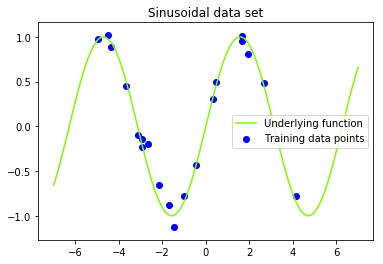

In [14]:
s = 0.1  # noise variance
y_train = y(x_train, s)  # observed target values (y)

plt.title('Sinusoidal data set')
plt.plot(x_star, f(x_star), color='lawngreen', label='Underlying function')
plt.scatter(x_train, y_train, color='b', label='Training data points')
plt.legend()
plt.show()

In [15]:
def gp_regression_noisy(X, y, k, x_star, s_f, s_n, l):
    # calculate mean
    Lxx = np.linalg.cholesky(k(X, X, s_f, l) + s_n * np.eye(X.shape[0]))
    a = np.linalg.solve(Lxx.T, np.linalg.solve(Lxx, y))
    mu = k(X, x_star, s_f, l).T @ a
    
    # calculate variance
    v = np.linalg.solve(Lxx, k(X, x_star, s_f, l))
    var = k(x_star, x_star, s_f, l) - v.T @ v + s_n

    return mu, var

In [16]:
# def sample(mu, var, N):
#     L = np.linalg.cholesky(var)  # TODO: should this be s_n (noise variance) or leave as 1e-6
#     f_post = mu + L @ np.random.normal(size=(n, N))
#     return f_post

In [17]:
s_f = 1  # signal variance
s_n = 1e-1  # noise variance
l = 1  # lengthscale

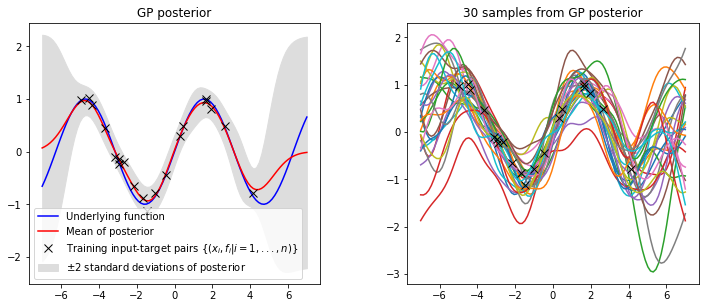

In [18]:
mu, var = gp_regression_noisy(x_train, y_train, kernel, x_star, s_f, s_n, l)
std = np.diag(var)

f_post = sample(mu, var, epsilon, N=30)

fig = plt.figure(figsize=(12, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# plot underlying function, training data, posterior mean and +/- 2 standard deviations
plt.subplot(2, 2, 1)
plt.title('GP posterior')
plt.fill_between(x_star.flatten(), mu.flatten()-2*std, mu.flatten()+2*std, label='$\pm$2 standard deviations of posterior', color="#dddddd")
plt.plot(x_star, f(x_star), 'b-', label='Underlying function')
plt.plot(x_star, mu, 'r-', label='Mean of posterior')  # plot mean of posterior
plt.plot(x_train, y_train, 'kx', ms=8 ,label='Training input-target pairs $\{(x_i, f_i | i = 1,...,n)\}$')
plt.legend()

# plot samples from posterior
plt.subplot(2, 2, 2)
plt.title('%i samples from GP posterior' % num_samples)
plt.plot(x_star, f_post)  # plot samples from posterior
plt.plot(x_train, y_train, 'kx', ms=8 ,label='Training input-target pairs $\{(x_i, f_i | i = 1,...,n)\}$')
plt.show()

# plt.title('GP posterior')
# plt.fill_between(x_star.flatten(), mu.flatten()-2*std, mu.flatten()+2*std, label='$\pm$2 standard deviations of posterior', color="#dddddd")
# plt.plot(x_star, f_post)  # plot samples from posterior
# plt.plot(x_star, f(x_star), '*', color='lawngreen', label='Underlying function')
# plt.plot(x_star, mu)  # plot mean of posterior
# plt.plot(x_train, y_train, 'bs', ms=4 ,label='Training input-target pairs $\{(x_i, f_i | i = 1,...,n)\}$')
# # plt.legend()
# plt.show()

We have now successfuly fitted implemented Gaussian process regression for both noise free and noisy data. However, in many practical applications, it may not be easy to specify all aspects of the covariance function, in particular, the free parameters. For this reason we will now look into applying Bayesian inference to Gaussian process regression so that we can infer the hyper-parameters from our data, providing automatic Ocam's razor.

## Hyper-parameter Optimisation using Marginal Likelihood

The marginal likelihood (or evidence) $p(\mathbf{y}|X)$ is the integral of the likelihood times the prior,

$$
p(\mathbf{y}|X) = \int p(\mathbf{y}| \mathbf{f}, X) p(\mathbf{f}|X) d \mathbf{f}.
$$

The name arises due to the marginalisation over the function values $\mathbf{f}$. The Gaussian process model leads to a prior that is Gaussian $\mathbf{f}|X \sim \mathcal{N}(0, K)$, which can be written in log form as,

$$
\text{log}p(\mathbf{f}|X) = - \frac{1}{2} \mathbf{f}^T K^{-1} \mathbf{f} - \frac{1}{2} \text{log}|K| - \frac{n}{2} \text{log}2\pi.
$$

The likelihood is assumed to be a factorized Gaussian $\mathbf{y}|\mathbf{f} \sim \mathcal{N}(\mathbf{f}, K + \sigma_n^2 \mathbf{I})$ so we can use Equations A.7 and A.8 (page 200) from from [Rasmussen and Williams](http://www.gaussianprocess.org/gpml/) to perform the integration. This results in the log marginal likelihood,

$$
\text{log}p(\mathbf{y}|X) = - \frac{1}{2} \mathbf{y}^T (K + \sigma_n^2 \mathbf{I})^{-1} \mathbf{y} - \frac{1}{2} \text{log}|K + \sigma^2_n \mathbf{I} | - \frac{n}{2} \text{log}2\pi
$$

Referring back to the algorithm in the previous section we can compute the log marginal likelihood

**input**: $\mathbf{X}$ (inputs), $\mathbf{y}$ (targets), $k$ (covariance function), $\sigma_n^2$ (noise level), $\mathbf{x}_*$ (test input)

\begin{align}
L &:= \text{cholesky}(K + \sigma_n^2 I) \\
\mathbf{\alpha} &:= L^T\backslash(L\backslash\mathbf{y}) \\
\bar{f}_* &:= \mathbf{k}_*^T\mathbf{\alpha} \\
\mathbf{v} &:= L \backslash \mathbf{k}_* \\
\mathbb{V}[f_*] &:= k(\mathbf{x}_*, \mathbf{x}_*) - \mathbf{v}^T \mathbf{v} \\
\text{log}p(\mathbf{y}|X) &= - \frac{1}{2} \mathbf{y}^T \mathbf{\alpha} - \sum_i L_{ii} - \frac{n}{2} \text{log}2\pi
\end{align}

**return**: $\bar{f}_*$ (mean), $\mathbb{V}[f_*]$ (variance), $text{log}p(\mathbf{y}|X)$ (log marginal likelihood)

In [19]:
import scipy.optimize as opt

def dKdL(x1, x2, s_f, l):
    return s_f**2 * np.exp((-cdist(x1, x2)**2) / (2*l**2)) * (-cdist(x1, x2)**2) / (l**3)

def dKdsf(x1, x2, s_f, l):
    return  2*s_f * np.exp((-cdist(x1, x2)**2) / (2*l**2))

def dKdTheta(a,iKxx, dKdt):    
    return 0.5 * np.trace((a @ a.T - iKxx) @ dKdt)

def f_opt(x, *args):
    # return the value of the objective at x return val
    X, y, k, x_star = args
    s_f, l, s_n = x
    
    Lxx = np.linalg.cholesky(k(X, X, s_f, l) + s_n*np.eye(X.shape[0])) #TODO: _sigma^2I 
    a = np.linalg.solve(Lxx.T, np.linalg.solve(Lxx, y))
    v = np.linalg.solve(Lxx, k(X, x_star, s_f, l))
    
#     return -(- 0.5 * y.T @ a - np.log(np.linalg.det(Lxx)) - X.shape[0]*np.log(2 * math.pi)/2)
    return -(- 0.5 * y.T @ a - np.trace(np.log(Lxx)) - X.shape[0]*np.log(2 * math.pi)/2)

def dfx(x, *args):
    # return the gradient of the objective at x return val
    X, y, k, x_star = args
    s_f, l, s_n = x
    
    Kxx = k(X, X, s_f, l)
    Lxx = np.linalg.cholesky(Kxx + s_n*np.eye(X.shape[0])) #TODO: _sigma^2I 
    a = np.linalg.solve(Lxx.T, np.linalg.solve(Lxx, y))
    
    iKxx = np.linalg.inv(Kxx + s_n*np.eye(X.shape[0]))
    
    J = np.empty([3,])
    J[0] = dKdTheta(a, iKxx, dKdsf(X, x_star, s_f, l))
    J[1] = dKdTheta(a, iKxx, dKdL(X, x_star, s_f, l))
    
    I = np.zeros([x_train.shape[0], x_star.shape[0]])
    np.fill_diagonal(I, 1)

    J[2] = dKdTheta(a, iKxx, I)  # TODO: Is this correct for noise variance gradient???
    
    return -J

bounds = [[0, np.inf], [0, np.inf], [0.0001, np.inf]]
args = (x_train, y_train, kernel, x_star)
x0 = [s_f, l, s_n]  # [s_f, l, s_n]
res = opt.fmin_l_bfgs_b(f_opt, x0, fprime=dfx, args=args, bounds=bounds)
# res = opt.fmin_l_bfgs_b(f_opt, x0, args=args, approx_grad=True, bounds=bounds)
print(res)

(array([0.61415041, 0.64178623, 0.06145363]), array([[8.41663877]]), {'grad': array([ 0.99380658,  1.22308726, 66.71445447]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 26, 'nit': 1, 'warnflag': 2})


/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log
/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-p

In [20]:
def gp_regression_noisy(X, y, k, x_star, s_f, s_n, l):
    # calculate mean
    Lxx = np.linalg.cholesky(k(X, X, s_f, l) + s_n*np.eye(X.shape[0])) #TODO: _sigma^2I 
    a = np.linalg.solve(Lxx.T, np.linalg.solve(Lxx, y))
    mu = k(X, x_star, s_f, l).T @ a
    
    # calculate variance
    v = np.linalg.solve(Lxx, k(X, x_star, s_f, l))
    var = k(x_star, x_star, s_f, l) - v.T @ v + s

    return mu, var

In [21]:
# def sample(mu, var, epsilon, N):
#     L = np.linalg.cholesky(var + epsilon*np.eye(n))
#     f_post = mu + L @ np.random.normal(size=(n, N))
#     return f_post

In [22]:
s_f = res[0][0] # signal variance
l = res[0][1]  # lengthscale
s_n = res[0][2]  # noise variance

mu, var = gp_regression_noisy(x_train, y_train, kernel, x_star, s_f, s_n, l)
std = np.diag(var)

f_post = sample(mu, var, epsilon, N=20)

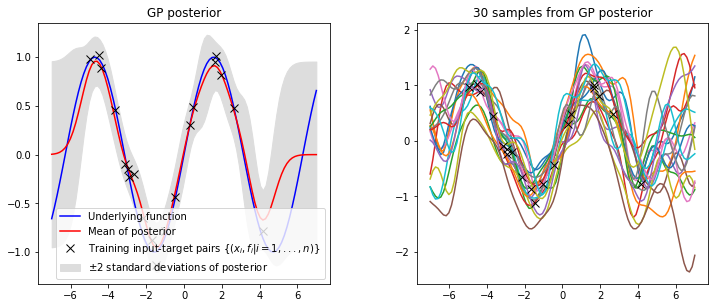

In [23]:
fig = plt.figure(figsize=(12, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# plot underlying function, training data, posterior mean and +/- 2 standard deviations
plt.subplot(2, 2, 1)
plt.title('GP posterior')
plt.fill_between(x_star.flatten(), mu.flatten()-2*std, mu.flatten()+2*std, label='$\pm$2 standard deviations of posterior', color="#dddddd")
plt.plot(x_star, f(x_star), 'b-', label='Underlying function')
plt.plot(x_star, mu, 'r-', label='Mean of posterior')  # plot mean of posterior
plt.plot(x_train, y_train, 'kx', ms=8 ,label='Training input-target pairs $\{(x_i, f_i | i = 1,...,n)\}$')
plt.legend()

# plot samples from posterior
plt.subplot(2, 2, 2)
plt.title('%i samples from GP posterior' % num_samples)
plt.plot(x_star, f_post)  # plot samples from posterior
plt.plot(x_train, y_train, 'kx', ms=8 ,label='Training input-target pairs $\{(x_i, f_i | i = 1,...,n)\}$')
plt.show()